#### Implementing HuggingFace's XLNet ####

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import XLNetConfig, XLNetLMHeadModel
from common import get_text, num_params, set_seed, get_tensors
from einops import rearrange
from tqdm import trange
from autoregressive_wrapper import AutoregressiveWrapper

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set seed so that the random results that are generated can be reproduced
set_seed(123)
#Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#Get the text
text = get_text()

In [4]:
#Get the Tensors for the text
t, vocab = get_tensors(text)
t = t.to(device)

Vocab size: 39


In [5]:
config = XLNetConfig(
  vocab_size=len(vocab),
  d_model=16,
  n_layer=2,
  n_head=1,
  d_inner=128, 
)
set_seed(4)
model = XLNetLMHeadModel(config)
model.to(device)

XLNetLMHeadModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(39, 16)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=16, out_features=128, bias=True)
          (layer_2): Linear(in_features=128, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=Tr

In [6]:
model

XLNetLMHeadModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(39, 16)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=16, out_features=128, bias=True)
          (layer_2): Linear(in_features=128, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=Tr

In [7]:
model.num_parameters()

12007

In [8]:
def forward(train = True):
    if train:
        model.train()
        out = model(t[:, :-1])
        logits = out.logits
        B,S,V = logits.shape # batch size, input size, vocabulary

        # continuguous(): doesn't work if you dont do it.
        # flatten because F.cross_entropy() doesn't work.
        logits_flat = logits.view(-1, V)             # b, s, v -> b * s, v
        target_flat = t[:, 1:].contiguous().view(-1) # b, s    -> b * s  
        loss = F.cross_entropy(logits_flat, target_flat)
        return logits, loss
    else:
        model.eval()
        logits = model(t)
        return logits
    

# train
n_steps = 100
optim = torch.optim.Adam(model.parameters())
all_losses = []
pbar = trange(n_steps) # progress bar
for i in pbar:
    if i:
        pbar.set_description(f"Loss: {all_losses[-1]:.3f}")
        
    logits, loss = forward(True)
    optim.zero_grad() # removes previous looks gradient buffers
    loss.backward()   # fill gradient buffers
    optim.step()      # buffer -> update weights
    all_losses.append(loss.item())

Loss: 2.978: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


Number of parameters =  12007


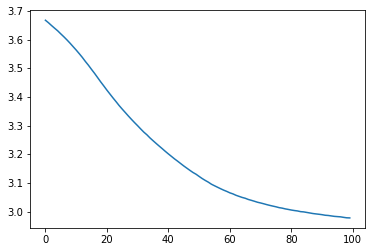

In [9]:
plt.plot(all_losses)
print("Number of parameters = ", model.num_parameters())

In [10]:
input_tokens = [vocab[x] for x in "artist"]
out = model.generate(torch.Tensor([input_tokens]).long().to(device), max_len = 128).tolist()
print(out)

[[13, 30, 32, 21, 31, 32, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
